In [1]:
import pyprob
%matplotlib inline
import matplotlib.pyplot as plt
from pyprob import Model
import numpy as np

# Anomaly analysis by conditioning on tail regions

In this example we will have a stochastic model that has a asymmetric distribution with a long tail of events. We will use probabilistic programming to **sample only events in the tail**


The Example Model we will be considering is two "particles" whose energies are uniformly distributed. However

* the energy of particle 1 is sampled from the interval [0,1]
* the energy of particle 2 is sampled from the interval [0,1.5]

Each particle can either be detected (be visible) or not. In this example the "reconstruction efficiency" is 50%

The "observed" quantity a binary output that is 

* zero if the missing energy is less that 1.2
* one if the missing energy is greater than 1.2


In [2]:
import math
import pyprob
from pyprob import Model
from pyprob.distributions import Normal, Uniform
import torch
class ConditioningOnTailExample(Model):
    def __init__(self):
        super().__init__(name="ConditioningOnTailExample")

    def forward(self):
        # sample the (latent) mean variable to be inferred:
        a = pyprob.sample(Uniform(0,1), name = 'input1')
        b = pyprob.sample(Uniform(0,1.5), name = 'input2')

        a_visible = pyprob.sample(pyprob.distributions.Categorical([0.5,0.5]))
        b_visible = pyprob.sample(pyprob.distributions.Categorical([0.5,0.5]))
        
        total_energy = a + b
        visible_energy = 0
        if a_visible == 1:
            visible_energy += a
        if b_visible == 1:
            visible_energy += b
        
        true_missing_energy = total_energy - visible_energy
        missing_energy = pyprob.sample(pyprob.distributions.Normal(true_missing_energy, 0.05))
        
        probs = [0,1] if missing_energy > 1.2 else [1,0]
        obs_distr = pyprob.distributions.Categorical(probs)

        pyprob.observe(obs_distr, name='obs0') # NOTE: observe -> denotes observable variables
        return {
            'E1': a,
            'E2': b,
            'isVisible_1': a_visible,
            'isVisible_2': b_visible, 
            'obs_missingE': missing_energy,
            'trueMissingE': true_missing_energy
        }

model = ConditioningOnTailExample()

In order to be able to do inferene, we learn the inference network.

In [3]:
model.learn_inference_network(
    num_traces=10000,
    observe_embeddings={'obs0': {'dim': 32, 'depth': 3}}
)

Creating new inference network...
Observable obs0: observe embedding not specified, using the default FEEDFORWARD.
Observe embedding dimension: 32
Train. time | Epoch| Trace     | Init. loss| Min. loss | Curr. loss| T.since min | Traces/sec
New layers, address: 16__forward__a__Uniform__1, distribution: Uniform
New layers, address: 36__forward__b__Uniform__1, distribution: Uniform
New layers, address: 58__forward__a_visible__Categorical(len_probs:2)__..., distribution: Categorical
New layers, address: 80__forward__b_visible__Categorical(len_probs:2)__..., distribution: Categorical
New layers, address: 152__forward__missing_energy__Normal__1, distribution: Normal
Total addresses: 5, parameters: 10,103
0d:00:00:16 | 1    | 10,048    | +1.28e-01 | -2.52e-01 | -3.88e-02 | 0d:00:00:04 | 616.0                              


## Inference

let's condition on events in the tail, that is the observed value of the binary indicator is one.

In [4]:
condition  = {'obs0': 1}

prior = model.prior_distribution(
    num_traces=2000,
)
posterior = model.posterior_distribution(
    num_traces=2000,
    inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING_WITH_INFERENCE_NETWORK,
    observe=condition
)

Time spent  | Time remain.| Progress             | Trace     | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 2000/2000 | 1,110.25       
Time spent  | Time remain.| Progress             | Trace     | Traces/sec
0d:00:00:26 | 0d:00:00:00 | #################### | 2000/2000 | 76.41       


In [5]:
prior_samples = [prior.sample() for x in range(1000)]
post_samples  = [posterior.sample() for x in range(1000)]

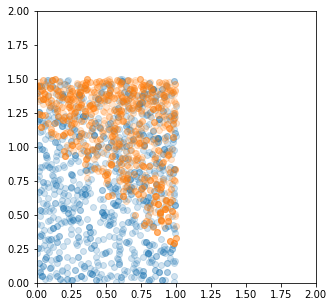

In [6]:
plt.scatter([x['E1'].numpy() for x in prior_samples],[x['E2'].numpy() for x in prior_samples], alpha = 0.2)
plt.scatter([x['E1'].numpy() for x in post_samples],[x['E2'].numpy() for x in post_samples], alpha = 0.2)
plt.xlim(0,2)
plt.ylim(0,2)
plt.gcf().set_size_inches(5,5)

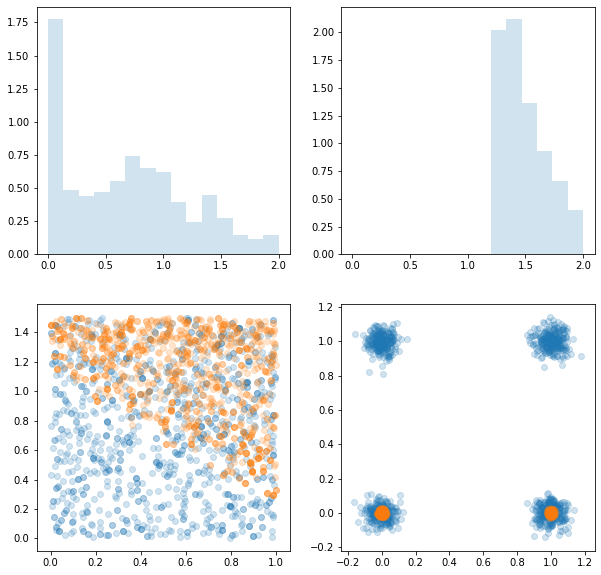

In [7]:
f, axarr = plt.subplots(2,2)
f.set_size_inches(10,10)
edges = np.linspace(0,2,16)
axarr[0,0].hist([x['obs_missingE'].numpy() for x in prior_samples], bins = edges, density = True, alpha = 0.2)
axarr[0,1].hist([x['obs_missingE'].numpy() for x in post_samples], bins = edges, density = True, alpha = 0.2)

axarr[1,0].scatter(
    [x['E1'].numpy() for x in prior_samples],
    [x['E2'].numpy() for x in prior_samples],
    alpha = 0.2
)
axarr[1,0].scatter(
    [x['E1'].numpy() for x in post_samples],
    [x['E2'].numpy() for x in post_samples],
    alpha = 0.2
)


axarr[1,1].scatter(
    [x['isVisible_1'].numpy() + np.random.normal(0,0.05) for x in prior_samples],
    [x['isVisible_2'].numpy() + np.random.normal(0,0.05) for x in prior_samples],
    alpha = 0.2
)
axarr[1,1].scatter(
    [x['isVisible_1'].numpy() + np.random.normal(0,0.01)  for x in post_samples],
    [x['isVisible_2'].numpy() + np.random.normal(0,0.01)  for x in post_samples],
    alpha = 0.2
)
